# Wprowadzenie do sieci neuronowych i uczenia maszynowego - Sieci Neuronowe


---

**Prowadzący:** Piotr Baryczkowski, Jakub Bednarek<br>
**Kontakt:** piotr.baryczkowski@put.poznan.pl<br>

---

## Cel ćwiczeń:

* zapoznanie się z pojęciem **zbioru danych** i jego charakterystyką,
* wykorzystanie podstawowych warstw neuronowych,
* implementacja procesu uczenia sieci neuronowej + *good practices*

In [1]:
import numpy as np
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1+cu121
CUDA available: True


## Zbiór danych

### Wprowadzenie oraz popularne zbiory danych

Odpowiednie przygotowanie zbioru danych odgrywa znaczącą rolę w uczeniu sieci neuronowych. Zazwyczaj zbiory danych zawierają 3 pozbiory:

* treningowy - wykorzystywany do uaktualniania wag modelu neuronowego,
* walidacyjny - do oceny modelu po każdej **epoce**,
* testowy - do porównania modelu z innymi rozwiązaniami.

**Uwaga:** bardzo często popularne zbiory danych nie posiadają zbioru testowego, ponieważ nie prowadzą tzw. **leaderboard**.

Najpopularniejsze zbiory danych:

* **MNIST**,
* eMNIST,
* Caltech 101/256,
* Cityscapes,
* Kitty,
* LFW Face Dataset,
* ImageNet

Więcej informacji: [wiki](https://en.wikipedia.org/wiki/List_of_datasets_for_machine-learning_research) [kaggle](https://www.kaggle.com/datasets) [google](https://toolbox.google.com/datasetsearch)

### Obsługa zbioru danych w PyTorch

Kod do przetwarzania danych może stać się nieczytelny i trudny do utrzymania; idealnie chcielibyśmy, aby kod związany z naszym zestawem danych był oddzielony od kodu, który odpowiada za uczenie modelu. PyTorch udostępnia dwie klasy do obsługi danych: `torch.utils.data.DataLoader` i `torch.utils.data.Dataset`, które pozwalają na użycie zarówno gotowych zestawów danych, jak i własnych. `Dataset` przechowuje próbki i ich odpowiadające etykiety, a `DataLoader` jest swego rodzaju nakładką na obiekt `Dataset`, umożliwiając łatwy dostęp do próbek - ładowanie danych, dzielenie danych na podzbiory (_ang. batch_). [link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

#### Tworzenie zbioru danych

In [2]:
dataset_size = 10

# zbiór danych składający się z losowych obrazków o rozmiarze (32, 32, 3) oraz etykiet po kolei od 0 do dataset_size
x = [np.random.uniform(size=(32, 32, 3)) for _ in range(dataset_size)]
y = [i for i in range(dataset_size)]

tensor_x = torch.Tensor(x)
tensor_y = torch.Tensor(y)

# utworzenie "iteratora" zbioru danych
dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)
dataloader = torch.utils.data.DataLoader(dataset)

<ipython-input-2-2ea1c1efc034>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  tensor_x = torch.Tensor(x)


#### Iterowanie po zbiorze danych

In [3]:
for x, y in dataloader:
  print(x.shape, y)

torch.Size([1, 32, 32, 3]) tensor([0.])
torch.Size([1, 32, 32, 3]) tensor([1.])
torch.Size([1, 32, 32, 3]) tensor([2.])
torch.Size([1, 32, 32, 3]) tensor([3.])
torch.Size([1, 32, 32, 3]) tensor([4.])
torch.Size([1, 32, 32, 3]) tensor([5.])
torch.Size([1, 32, 32, 3]) tensor([6.])
torch.Size([1, 32, 32, 3]) tensor([7.])
torch.Size([1, 32, 32, 3]) tensor([8.])
torch.Size([1, 32, 32, 3]) tensor([9.])


#### Tasowanie

In [4]:
dataloader_shuffled = torch.utils.data.DataLoader(dataset, shuffle=True)

for x, y in dataloader_shuffled:
  print(x.shape, y)

torch.Size([1, 32, 32, 3]) tensor([8.])
torch.Size([1, 32, 32, 3]) tensor([3.])
torch.Size([1, 32, 32, 3]) tensor([7.])
torch.Size([1, 32, 32, 3]) tensor([0.])
torch.Size([1, 32, 32, 3]) tensor([9.])
torch.Size([1, 32, 32, 3]) tensor([5.])
torch.Size([1, 32, 32, 3]) tensor([4.])
torch.Size([1, 32, 32, 3]) tensor([1.])
torch.Size([1, 32, 32, 3]) tensor([2.])
torch.Size([1, 32, 32, 3]) tensor([6.])


#### Mapowanie

In [5]:
class MappedDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, transform_func):
    self.dataset = dataset
    self.transform_func = transform_func

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    data, label = self.dataset[idx]
    return self.transform_func(data, label)


def map(x, y):
  y = y * 2
  return x, y


dataset_mapped = MappedDataset(dataset, map)
dataloader_mapped = torch.utils.data.DataLoader(dataset_mapped)

for x, y in dataloader_mapped:
  print(x.shape, y)

torch.Size([1, 32, 32, 3]) tensor([0.])
torch.Size([1, 32, 32, 3]) tensor([2.])
torch.Size([1, 32, 32, 3]) tensor([4.])
torch.Size([1, 32, 32, 3]) tensor([6.])
torch.Size([1, 32, 32, 3]) tensor([8.])
torch.Size([1, 32, 32, 3]) tensor([10.])
torch.Size([1, 32, 32, 3]) tensor([12.])
torch.Size([1, 32, 32, 3]) tensor([14.])
torch.Size([1, 32, 32, 3]) tensor([16.])
torch.Size([1, 32, 32, 3]) tensor([18.])


#### Filtrowanie

In [6]:
class FilteredDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, threshold):
    self.filtered_data = [
      (data, label) for data, label in dataset if label > threshold
    ]

  def __len__(self):
    return len(self.filtered_data)

  def __getitem__(self, idx):
    return self.filtered_data[idx]


dataset_filtered = FilteredDataset(dataset, 5)

dataloader_filtered = torch.utils.data.DataLoader(dataset_filtered)

for x, y in dataloader_filtered:
  print(x.shape, y)

torch.Size([1, 32, 32, 3]) tensor([6.])
torch.Size([1, 32, 32, 3]) tensor([7.])
torch.Size([1, 32, 32, 3]) tensor([8.])
torch.Size([1, 32, 32, 3]) tensor([9.])


#### Grupowanie

In [7]:
dataloader_batch = torch.utils.data.DataLoader(dataset, batch_size=5)

for x, y in dataloader_batch:
  print(x.shape, y)

torch.Size([5, 32, 32, 3]) tensor([0., 1., 2., 3., 4.])
torch.Size([5, 32, 32, 3]) tensor([5., 6., 7., 8., 9.])


#### Składanie wielu operacji na raz

In [8]:
dataset_mix = MappedDataset(dataset, map)
dataset_mix = FilteredDataset(dataset_mix, 6)

dataloader_mix = torch.utils.data.DataLoader(dataset_mix, shuffle=True, batch_size=5)

for x, y in dataloader_mix:
  print(x[0, 0, 0, 0], x.shape, y)

tensor(0.1660) torch.Size([5, 32, 32, 3]) tensor([18., 16.,  8., 14., 12.])
tensor(0.1517) torch.Size([1, 32, 32, 3]) tensor([10.])


#### Zadanie 1

Stwórz zbiór danych (bez podziału na zbiory treningowe, walidacyjne i treningowe) składający się z 10000 elementów, zawierający pary (x, y) danych
dla funkcji **sinus**. Dane x niech będą z zakresu [-2 * PI, 2 * PI], y - odpowiadające im wartości funkcji sinus.

Następnie utwórz providera za pomocą TensorFlow Dataset API, który będzie:

* tasował dane
* mapował tak, aby dane x, z zakresu [-2 \* PI, 0), były transformowane do przedziału [0, 2 \* PI)

Podpowiedź: (x + 2PI) % 2PI,
* grupował dane w batche o rozmiarze 32

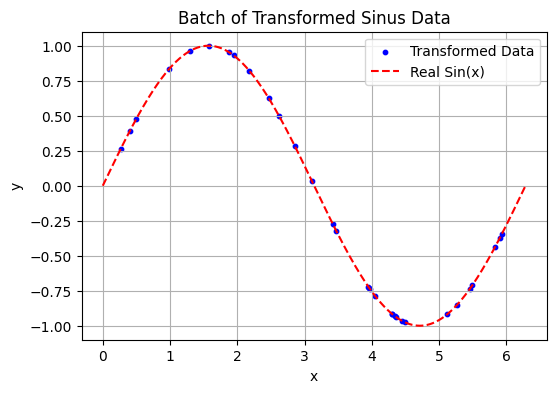

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


dataset_size = 10000

x = np.linspace(-2*np.pi, 2*np.pi, dataset_size)
y = np.sin(x)

def transform_sinus(x, y):
  x_transformed = (x+2*np.pi) % (2*np.pi)
  return x_transformed, y

dataset = TensorDataset(torch.Tensor(x), torch.Tensor(y))
mappedDataset = MappedDataset(dataset, transform_sinus)
dataloader = DataLoader(mappedDataset)

# Too many examples
# for x, y in dataloader:
#   print(x, y)

# Let's print just one batch
dataloader = DataLoader(mappedDataset, batch_size=32, shuffle=True)
for i, (x,y) in enumerate(dataloader):
  if(i == 1):
    break
  # Convert tensors to numpy arrays for plotting
  x_batch = x.numpy()
  y_batch = y.numpy()

  # Plot the batch as scatter points
  plt.figure(figsize=(6, 4))
  plt.scatter(x_batch, y_batch, color='b', label='Transformed Data', s=10)  # 's' controls the point size

  # Add the real sine curve for comparison
  x_real = np.linspace(0, 2 * np.pi, 1000)
  y_real = np.sin(x_real)
  plt.plot(x_real, y_real, color='r', label='Real Sin(x)', linestyle='--')

  plt.title('Batch of Transformed Sinus Data')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.grid(True)
  plt.legend()
  plt.show()

### Popularne zbiory danych

Biblioteka PyTorch zawiera gotowe funkcje wczytujące dla niektórych zbiorów danych. Większość gotowych zbiorów danych możemy znaleźć w bibliotece *torchvision*. Tutaj możesz znaleźć dokładną listę dostępnych zbiorów danych - [link](https://pytorch.org/vision/stable/datasets.html)

Jednym z popularniejszych zbiorów danych jest MNIST. Jest to zbiór zawierający cyfry pochodzące z pisma odręcznego wraz z ich przypisanymi etykietami ('1', '2', etc.). Poniżej przykładowe pobranie i wykorzystanie zbioru MNIST.

In [10]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

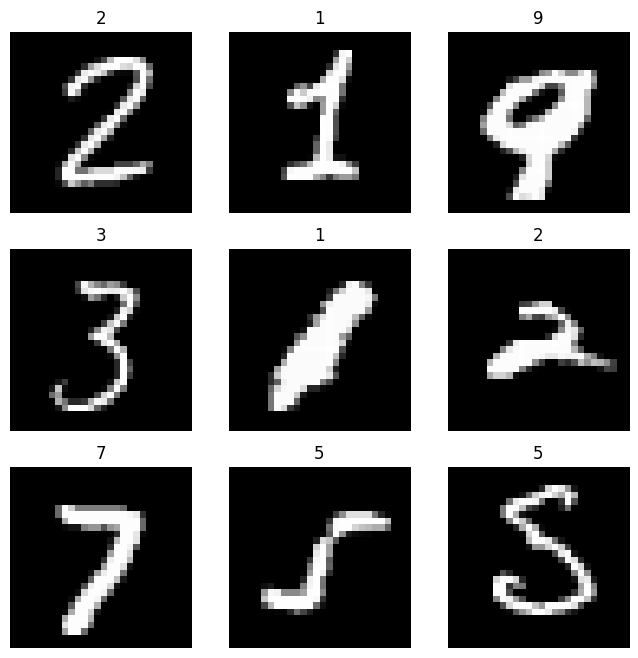

In [11]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Podstawowe warstwy neuronowe

Przy projektowaniu sieci neuronowych możemy wyróżnić podstawowe operacje (warstwy), które się powtarzają. Dla wygody, PyTorch zawiera gotowe implementacje najprostszych z nich, oraz udostępnia interfejsy do tworzenia własnych, bardziej skomplikowanych.

Operacje możemy podzielić na:
* **uczalne** - zawierające zmienne uczalne (np. *w* i *b* w warstwie w pełni połączonej),
* **nieuczalne** - takie, które wykonują pewne charakterystyczne działania na danych, jednak nie potrzebują do tego zmiennych, które będą uczone w trakcie propagacji gradientu.

Poniżej zaprezentowane zostały popularne operacje uczalne i nieuczalne.

**Uwaga**
Wszystkie operacje są reprezentowane jako klasy.

### Uczalne



Dzięki predefiniowanym warstwom nie ma potrzeby samodzielnej deklaracji nowych zmiennych. Wszystkie zmienne uczone są deklarowane (zgodnie z implementacją danej warstwy) wewnątrz obiektu, a następnie przechowywane.

Do zmiennych uczonych można dostać się poprzez własność *state_dict* (lub *parameters*).

In [12]:
m = torch.nn.Linear(5, 5)

m.state_dict()

OrderedDict([('weight',
              tensor([[ 0.1174, -0.2308,  0.2312, -0.3007,  0.2594],
                      [ 0.3014, -0.2222,  0.1950, -0.0427, -0.3005],
                      [ 0.1241, -0.1934,  0.2456,  0.2998, -0.4143],
                      [ 0.2319, -0.1011,  0.0064,  0.1977,  0.1005],
                      [-0.0714, -0.3344, -0.3274,  0.1598, -0.0510]])),
             ('bias', tensor([-0.3558,  0.0678,  0.2290,  0.2640, -0.0628]))])

#### Linear

Jest to warstwa w pełni połączona, która pobiera jako wejście wektor i produkuje na wyjściu wektor o długości równej rozmiarowi warstwy (liczby neuronów).

In [13]:
# definicja warstwy
linear1 = torch.nn.Linear(8, 2)

# inferencja
x = torch.ones([8])
y = linear1(x)

# rozmiar wejściowego oraz wyjściowego tensora
print(x.shape, y.shape)

# zmienne uczone
state_dict = linear1.state_dict()
print(f"Wagi w warstwie linear: {state_dict['weight']}")
print(f"Bias'y w warstwie linear: {state_dict['bias']}")

torch.Size([8]) torch.Size([2])
Wagi w warstwie linear: tensor([[ 0.2057, -0.1315, -0.0552, -0.2976, -0.2647, -0.1617,  0.1632, -0.0181],
        [-0.1761, -0.0144, -0.1503,  0.2503, -0.1009, -0.1236, -0.2847,  0.2657]])
Bias'y w warstwie linear: tensor([-0.2598, -0.1078])


#### Convolution

Warstwa w pełni połączona dobrze sprawdza się przy danych jednowymiarowych. W przypadku danych wielowymiarowych (jak obrazy) korzystanie z nich byłoby bardzo kosztowne obliczeniowo. Aby wykonać pojedynczą operację *Linear* z 128 neuronami na obrazie o rozmiarach (256, 256, 3) należałoby zadeklarować  256 * 256 * 3 * 128 = 25165824 zmiennych uczonych.

Popularnym rozwiązaniem efektywnego przetwarzania danych wielowymiarowych są operacje konwolucji ([link do wizualizacji](https://github.com/vdumoulin/conv_arithmetic)). Konwolucja (inaczej splot) w sieciach neuronowych intuicyjnie jest, tak samo jak *Linear*, kombinacją liniową danego podobszaru danych wielowymiarowych i zmiennych uczonych (inaczej *kernel*).

Konwolucja w PyTorch posiada szereg parametrów takich jak:
* liczba kanałów wejściowych - liczba kanałów w obrazie wejściowym,
* liczba kanałów wyjściowych - liczba kanałów "wyprodukowana" przez konwolucję,
* kernel_size - rozmiar kernela,
* stride - "rozstrzał" przetwarzanego podobszaru (patrz link do github),
* padding - dopełnienie dodane do wszystkich czterech stron danych wejściowych. Domyślnie: 0,

W porównaniu do przykładu przytoczonego powyżej, konwolucja z 128 filtrami, rozmiarem kernela równym (3, 3), dla takich samych danych wejściowych zawierałaby 3 * 3 * 3 * 128 = 3456, czyli ponad 7281 (!) razy mniej niż w przypadku *Linear*. Ponadto, w przetwarzaniu danych, w których zachodzą lokalne zależności (na obrazie sąsiadujące piksele reprezentują zazwyczaj ten sam obiekt) konwolucja sprawdza się o wiele lepiej niż *Linear*.

In [14]:
# definicja warstwy
conv1 = torch.nn.Conv2d(128, 128, (3, 3), (2, 2), 1)

# inferencja (przy pierwszym wywołaniu warstwy Linear1 zostaną stworzone zmienne uczone)
x = torch.ones([10, 128, 128, 3])
y = conv1(x)

# rozmiar wejściowego oraz wyjściowego tensora
print(x.shape, y.shape)

# zmienne uczone
state_dict = conv1.state_dict()
print(f"Wagi w warstwie conv: {state_dict['weight'].shape}")
print(f"Bias'y w warstwie conv: {state_dict['bias'].shape}")

torch.Size([10, 128, 128, 3]) torch.Size([10, 128, 64, 2])
Wagi w warstwie conv: torch.Size([128, 128, 3, 3])
Bias'y w warstwie conv: torch.Size([128])


### Nieuczalne

Warstwy nieuczalne zazwyczaj wykonują pewne operacje techniczne, typu zmiana kształtu, skalowanie danych, lub są wykorzystywane w **regularyzacji** (o czym będzie mowa na kolejnych zajęciach).

#### Pooling

Jest to jedna z popularniejszych metod regularyzacji, polegająca na wykonaniu pewnej operacji na małym wycinku danych. Przykładowo MaxPooling2D, podobnie jak konwolucja 2D (patrz wizualizacje), wybiera podobszar obrazu o jakichs wymiarach (np. 2x2) a następnie wybiera maksymalny obiekt z tego okna, tworząc nowy obraz (np. zmniejszony 2-krotnie). Istnieją również inne metody poolingu:

* average - z okna obliczana jest średnia,
* median - z okna obliczana jest mediana,
* minimum - z okna wybierana jest najmniejsza wartość,
* itp.

In [15]:
# definicja warstwy
mp1 = torch.nn.MaxPool2d((2, 2), (2, 2))

# inferencja (przy pierwszym wywołaniu warstwy Linear1 zostaną stworzone zmienne uczone)
x = torch.ones([10, 3, 128, 128])
y = mp1(x)

# rozmiar wejściowego oraz wyjściowego tensora
print(x.shape, y.shape)

torch.Size([10, 3, 128, 128]) torch.Size([10, 3, 64, 64])


#### Flatten

Flatten jest prostą funkcją spłaszczającą **każdy element w batchu**. Przykładowo dla grupy 10 obrazów o pewnych wymiarach wyprodukowanych zostanie 10 wektorów (spłaszczonych do wektorów obrazów).

In [16]:
# definicja warstwy
ft1 = torch.nn.Flatten()

# inferencja (przy pierwszym wywołaniu warstwy Linear1 zostaną stworzone zmienne uczone)
x = torch.ones([10, 128, 128, 3])
x = x.permute(0, 3, 1, 2)  # [batch_size, height, width, channels] -> [batch_size, channels, height, width]
y = ft1(x)

# rozmiar wejściowego oraz wyjściowego tensora
print(x.shape, y.shape)

torch.Size([10, 3, 128, 128]) torch.Size([10, 49152])


## Proces uczenia sieci neuronowej

Proces uczenia sieci neuronowych składa się z kilku części. Po inicjalizacji modelu oraz zbioru danych następuje uczenie modelu składające się z wielu **epok**. Epoka to pojedyncze przeiterowanie po całym zbiorze danych (podzbiory treningowe i walidacyjne). Przy czym model jest uczony (bład jest propagowany) tylko na zbiorze treningowym. **Nigdy na zbiorach walidacyjnym i testowym.** Proces uczenia sieci neuronowej składa się (najczęściej) następujących części:

1. Inicjalizacja modelu,
2. Inicjalizacja zbioru danych,
3. Pętla treningowa,
  1. Uczenie na zbiorze treningowym (raz!),
  2. Ocena modelu na zbiorze walidacyjnym,
4. Ocena modelu na zbiorze testowym (opcjonalne)

#### Inicjalizacja modelu

**Uwaga:** Jeśli model składa się z następujących po sobie operacji, można opakować go dla wygody w strukturę *Sequential*, tak jak pokazano poniżej.

In [17]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [18]:
import torch.nn as nn
from torch.nn.modules.activation import ReLU


class MyModel(nn.Module):
    def __init__(self) -> None:
        """Model który na wejściu otrzymuje obraz a na wyjściu produkuje skalar

        W skład modelu wchodzą 3 warstwy konwolucyjne o rozmiarach 64, 32, 16 (out_channels),
        każda z rozmiarem kernela 5x5 oraz stride 2x2 (czyli obraz po każdej warstwie będzie 2 razy mniejszy)
        potem następuje spłaszczenie obrazu do wektora i przetwarzanie warstwami w pełni połączonymi.
        Wszystkie warstwy (oprócz wyjściowej) korzystają z funkcji aktywacji 'relu'
        """
        super(MyModel, self).__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=2, padding=1),
            ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, stride=2, padding=1),
            ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5, stride=2, padding=1),
            ReLU(),
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            ReLU(),
            nn.Linear(in_features=32, out_features=10),
            ReLU(),
            nn.Linear(in_features=10, out_features=10),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_relu_stack(x)
        x = self.flatten(x)
        return self.linear_relu_stack(x)


model = MyModel()
print(model)

MyModel(
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
)


#### Inicjalizacja zbioru danych

Jako zbiór danych wykorzystany zostanie zaprezentowany wcześniej zbiór **MNIST**.

In [19]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [20]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

### Proces uczenia sieci neuronowej

In [21]:
learning_rate = 1e-3
batch_size = 32
epochs = 5

In [22]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.297511  [   32/60000]
loss: 1.073037  [ 3232/60000]
loss: 0.362470  [ 6432/60000]
loss: 0.521501  [ 9632/60000]
loss: 0.248716  [12832/60000]
loss: 0.080324  [16032/60000]
loss: 0.103377  [19232/60000]
loss: 0.294623  [22432/60000]
loss: 0.165597  [25632/60000]
loss: 0.223611  [28832/60000]
loss: 0.048238  [32032/60000]
loss: 0.198628  [35232/60000]
loss: 0.476814  [38432/60000]
loss: 0.062288  [41632/60000]
loss: 0.130425  [44832/60000]
loss: 0.134148  [48032/60000]
loss: 0.042987  [51232/60000]
loss: 0.194999  [54432/60000]
loss: 0.034223  [57632/60000]
Test Error: 
 Accuracy: 96.8%, Avg loss: 0.099375 

Epoch 2
-------------------------------
loss: 0.015673  [   32/60000]
loss: 0.421198  [ 3232/60000]
loss: 0.126183  [ 6432/60000]
loss: 0.050038  [ 9632/60000]
loss: 0.093703  [12832/60000]
loss: 0.086492  [16032/60000]
loss: 0.306185  [19232/60000]
loss: 0.194042  [22432/60000]
loss: 0.235412  [25632/60000]
loss: 0.044689  [28832/60000

#### Zadanie 2

Stwórz sieć neuronową składającą się z:

* 3 warstw konwolucyjnych (kernel size = 5, liczba filtrów = 128, 64, 32, **bez stride (stride=1)**, aktywacja = relu, **padding='same'**)
* 3 warstw Max Pooling-u, każda znajdująca się za kolejną warstwą konwolucyjną (pool size = 2, **stride = 2**, padding=1, funkcja aktywacji: relu) (tzn. Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> ...),
* 3 warstw w pełni połączonych (rozmiary: 512, 128, **liczba klas**, funkcja aktywacji: relu)

Przetestuj swoją sieć na następujących zbiorach danych:

* Cifar 10
* Cifar 100

In [24]:
import numpy as np
import torch
import torch.nn as nn

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1+cu121
CUDA available: True


In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(NeuralNetwork, self).__init__()
        self.blocks = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = 5, stride = 1, padding = 'same'),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1),
            ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 5, stride = 1, padding = 'same'),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1),
            ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 5, stride = 1, padding = 'same'),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1),
            ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=5*5*32, out_features = 512),
            ReLU(),
            nn.Linear(in_features=512, out_features = 128),
            ReLU(),
            nn.Linear(in_features=128, out_features = num_classes),
        )

    def forward(self, x: torch.Tensor):
        return self.blocks(x)


model = NeuralNetwork(10)
print(model)


NeuralNetwork(
  (blocks): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=800, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=128, bias=True)
    (13): ReLU()
    (14): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [26]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
from torch.utils.data import DataLoader

batch_size = 32

train_dataloader = DataLoader(training_data, batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size, shuffle = True)

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.288568  [   32/50000]
loss: 2.133869  [ 3232/50000]
loss: 1.812789  [ 6432/50000]
loss: 1.524879  [ 9632/50000]
loss: 1.432020  [12832/50000]
loss: 1.694608  [16032/50000]
loss: 1.500523  [19232/50000]
loss: 1.823983  [22432/50000]
loss: 1.450866  [25632/50000]
loss: 1.689260  [28832/50000]
loss: 1.313642  [32032/50000]
loss: 1.397545  [35232/50000]
loss: 1.493183  [38432/50000]
loss: 1.381918  [41632/50000]
loss: 1.082064  [44832/50000]
loss: 1.521259  [48032/50000]
Test Error: 
 Accuracy: 53.6%, Avg loss: 1.273563 

Epoch 2
-------------------------------
loss: 1.609416  [   32/50000]
loss: 1.200276  [ 3232/50000]
loss: 1.355878  [ 6432/50000]
loss: 0.830917  [ 9632/50000]
loss: 0.901599  [12832/50000]
loss: 0.856656  [16032/50000]
loss: 1.044313  [19232/50000]
loss: 1.018919  [22432/50000]
loss: 1.187902  [25632/50000]
loss: 1.147108  [28832/50000]
loss: 0.952058  [32032/50000]
loss: 1.033254  [35232/50000]
loss: 0.932930  [38432/50000

## Pretrenowane sieci

Biblioteka udostępnia również **pretrenowane** modele. Tzn. takie, które zostały już wyuczone na pewnych zbiorach danych.

Istnieje wiele znanych, pretrenowanych sieci neuronowych:

* ResNet (w wersji 50, 100, itp.),
* Inception (V2, V3),
* VGG (16, 19),
* MobileNet,
* LinearNet

Poniżej zaprezentowany został przykład użycia jednej z nich.

In [29]:
from torchvision.models import resnet50, ResNet50_Weights

# Using pretrained weights:
resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet50(weights="IMAGENET1K_V1")
resnet50(pretrained=True)  # deprecated
resnet50(True)  # deprecated

# Using no weights:
resnet50(weights=None)
resnet50()
resnet50(pretrained=False)  # deprecated
resnet50(False)  # deprecated

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Ple

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Mounted at /content/drive


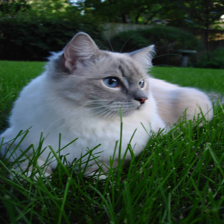

In [30]:
import numpy as np
from PIL import Image
import IPython.display
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
image_path = '/content/drive/My Drive/Colab Notebooks/cat.jpg'

im = Image.open(image_path)
im_resized = im.resize((224, 224))
IPython.display.display(im_resized)


In [31]:
# przygotowanie obrazka
im_numpy = np.array(im.resize((224, 224)))  # rozmiar który przyjmuje ResNet
im_torch = torch.Tensor(im_numpy).permute(2, 0, 1).unsqueeze(0)

# załadowanie pretrenowanego modelu i jego inferencja
from torchvision.models import resnet50, ResNet50_Weights
weights = ResNet50_Weights.IMAGENET1K_V1
model = resnet50(weights=weights)
model.eval()

print(im_torch.shape)
pred = model(im_torch)

# pobranie wyniku z sieci neuronowej
print(torch.argmax(pred, -1).numpy())

torch.Size([1, 3, 224, 224])
[818]


Zgodnie z klasami zawartymi w zbiorze danych ImageNet, odpowiedź 284 oznacza "Kot syjamski".

Przykładowe klasy:

* 21: 'kite',
* 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
* 23: 'vulture',
* 243: 'bull mastiff',
* 244: 'Tibetan mastiff',
* 245: 'French bulldog',
* 282: 'tiger cat',
* 283: 'Persian cat',
* 284: 'Siamese cat, Siamese',
* 285: 'Egyptian cat',

Wszystkie obecne w ImageNet klasy: [link](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

#### Zadanie 3

Spróbuj wykorzystać dowolną inną pretrenowaną sieć neuronową, zgodnie z powyższym schematem. Możesz spróbować załadować inny obraz.

Dostępne pretrenowane modele: [link](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

**Uwaga:** zwróć uwagę na rozmiary danych, które przyjmują poszczególne sieci neuronowe. Pełna dokumentacja, wraz z rozmiarami znajduje się pod [linkiem](https://keras.io/applications/).

In [32]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

im_numpy = np.array(im.resize((224, 224)))  # Rozmiar akceptowany przez EfficientNet
im_torch = torch.Tensor(im_numpy).permute(2, 0, 1).unsqueeze(0) / 255.0  # Normalizacja 0-1

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)
model.eval()

pred = model(im_torch)

# Pobranie wyniku z sieci neuronowej
class_id = torch.argmax(pred, -1).item()
class_name = weights.meta["categories"][class_id]

# Wyświetlenie klasyfikacji
print(f"Predicted class ID: {class_id}")
print(f"Predicted class name: {class_name}")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 220MB/s]


Predicted class ID: 282
Predicted class name: tiger cat
